In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

In [3]:
(train_data, val_data), info = tfds.load('ag_news_subset:1.0.0', #version 1.0.0
                                         split=['train[:90%]', 'train[90%:]+test'],
                                         with_info=True,
                                         as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.CHED00_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.CHED00_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [4]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles. News articles have been
    gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
    activity. ComeToMyHead is an academic news search engine which has been running
    since July, 2004. The dataset is provided by the academic comunity for research
    purposes in data mining (clustering, classification, etc), information retrieval
    (ranking, search, etc), xml, data compression, data streaming, and any other
    non-commercial activity. For more information, please refer to the link
    http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .
    
    The AG's news topic classification dataset is constructed by Xiang Zhang
    (xiang.zhang@nyu.edu) from the dataset above. It is used as a text
    classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann
    LeCu

In [5]:
class_names = info.features['label'].names
num_classes = info.features['label'].num_classes

print(f'The news are grouped into {num_classes} classes that are :{class_names}')

The news are grouped into 4 classes that are :['World', 'Sports', 'Business', 'Sci/Tech']


In [6]:
num_train = info.splits['train'].num_examples
num_val = info.splits['test'].num_examples

print(f'The number of training samples: {num_train} \nThe number of validation samples: {num_val}')

The number of training samples: 120000 
The number of validation samples: 7600


In [7]:
news_df = tfds.as_dataframe(train_data.take(10), info)

news_df.head(10)

,description,label
0,b'AMD #39;s new dual-core Opteron chip is desi...,3
1,b'Reuters - Major League Baseball\\Monday anno...,1
2,b'President Bush #39;s quot;revenue-neutral q...,2
3,b'Britain will run out of leading scientists u...,3
4,"b'London, England (Sports Network) - England m...",1
5,b'TOKYO - Sony Corp. is banking on the \\$3 bi...,0
6,b'Giant pandas may well prefer bamboo to lapto...,3
7,"b'VILNIUS, Lithuania - Lithuania #39;s main pa...",0
8,b'Witnesses in the trial of a US soldier charg...,0
9,"b'Dan Olsen of Ponte Vedra Beach, Fla., shot a...",1


In [8]:
buffer_size = 1000
batch_size = 32

train_data = train_data.shuffle(buffer_size)
train_data = train_data.batch(batch_size).prefetch(1)
val_data = val_data.batch(batch_size).prefetch(1)

In [9]:
for news, label in train_data.take(1):

  print(f'Sample news\n----\n {news.numpy()[:4]} \n----\nCorresponding labels: {label.numpy()[:4]}')

Sample news
----
 [b'ENGLAND coach Phil Larder has threatened Australia with  #39;payback #39; when the world champions meet their favourite enemy at Twickenham on Saturday.'
 b'The Latin American literary giant won the last laugh on book pirates by finely tuning the ending of his latest novel, "Memories of My Melancholy Whores."'
 b'Art collectors spend millions to buy masterpieces, but the masterpiece they buy today could prove to be virtually worthless tomorrow if they aren #39;t careful.'
 b"Sun Microsystems Inc.'s combative chief executive, Scott McNealy, fresh from resolving his long-running quarrel with archrival Microsoft Corp. , has found a new target for his wrath: Linux software maker Red Hat Inc."] 
----
Corresponding labels: [1 0 3 2]


In [10]:
max_features = 10000

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_features)

In [11]:
text_vectorizer.adapt(train_data.map(lambda description, label : description))

In [12]:
vocab = text_vectorizer.get_vocabulary()
vocab[:10]

['',
 '[UNK]',
 np.str_('the'),
 np.str_('a'),
 np.str_('to'),
 np.str_('of'),
 np.str_('in'),
 np.str_('and'),
 np.str_('on'),
 np.str_('for')]

In [13]:
sample_news = ['This weekend there is a sport match between Man U and Fc Barcelona',
               'Tesla has unveiled its humanoid robot that appeared dancing during the show!']


In [14]:
vectorized_news = text_vectorizer(sample_news)
vectorized_news.numpy()

array([[  40,  494,  186,   16,    3, 1567,  570,  159,  370,    1,    7,
        7486, 2556],
       [   1,   20,  876,   13,    1, 4845,   10, 1273,    1,  160,    2,
         532,    0]])

In [15]:
input_dim = len(text_vectorizer.get_vocabulary())
input_dim

10000

In [16]:
model = tf.keras.Sequential([
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=64, mask_zero=True),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [17]:
model.build(input_shape=(None,))  # input is a batch of strings
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, None, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,300 (2.61 MB)

 Trainable params: 683,300 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
batch_size = 32

train_steps = int(len(train_data)/batch_size)
val_steps = int(len(val_data)/batch_size)

In [20]:
# Train the model

history = model.fit(train_data,
                    epochs=25,
                    validation_data=val_data,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps
)

Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2637 - loss: 1.3859 - val_accuracy: 0.5016 - val_loss: 1.3109
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5207 - loss: 1.0930 - val_accuracy: 0.7434 - val_loss: 0.5958
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7157 - loss: 0.6893 - val_accuracy: 0.8520 - val_loss: 0.4592
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8235 - loss: 0.5205 - val_accuracy: 0.8487 - val_loss: 0.4202
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8387 - loss: 0.4747 - val_accuracy: 0.8668 - val_loss: 0.4009
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8559 - loss: 0.4338 - val_accuracy: 0.8635 - val_loss: 0.3892
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8536 - loss: 0.4456 - val_accuracy: 0.8734 - val_loss: 0.3613
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8678 - loss: 0.4151 - val_accu

In [21]:
import matplotlib.pyplot as plt

# function to plot accuracy and loss

def plot_acc_loss(history):

  model_history = history.history
  acc = model_history['accuracy']
  val_acc = model_history['val_accuracy']
  loss = model_history['loss']
  val_loss = model_history['val_loss']
  epochs = history.epoch

  plt.figure(figsize=(10,5))
  plt.plot(epochs, acc, 'r', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)

  # Create a new figure with plt.figure()
  plt.figure()

  plt.figure(figsize=(10,5))
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  plt.show()

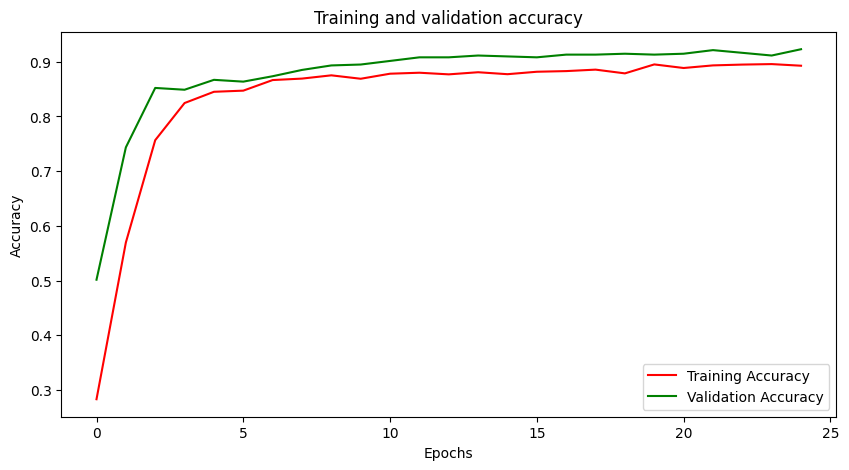

<Figure size 640x480 with 0 Axes>

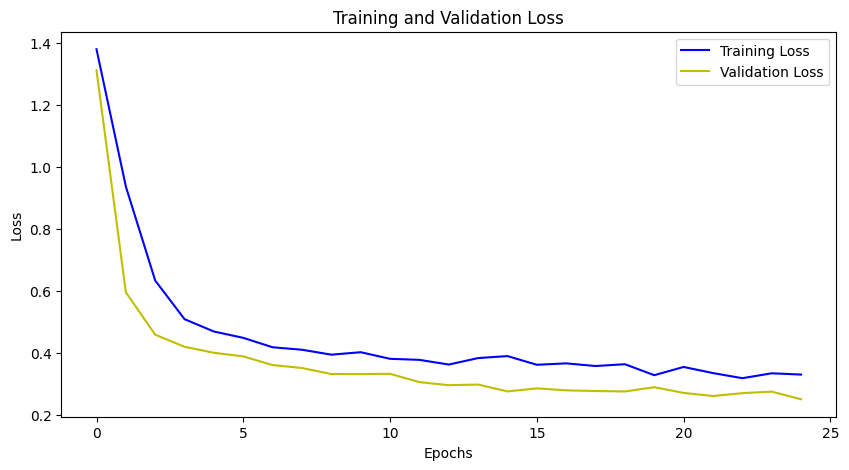

In [22]:
plot_acc_loss(history)

In [23]:
#Combining CNNs and RNNs for Text Classification

In [24]:
conv_rnn_model = tf.keras.Sequential([
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=64, mask_zero=True),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [25]:
conv_rnn_model.build(input_shape=(None,))
conv_rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, None, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,396 (2.87 MB)

 Trainable params: 751,396 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Compile the model

conv_rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
batch_size = 32

train_steps = int(len(train_data)/batch_size)
val_steps = int(len(val_data)/batch_size)


# Train the model

history = conv_rnn_model.fit(train_data,
                    epochs=25,
                    validation_data=val_data,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps
)

Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.2744 - loss: 1.3589 - val_accuracy: 0.6299 - val_loss: 0.8391
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6558 - loss: 0.8173 - val_accuracy: 0.7747 - val_loss: 0.6174
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7569 - loss: 0.6721 - val_accuracy: 0.8372 - val_loss: 0.4590
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8262 - loss: 0.5383 - val_accuracy: 0.8618 - val_loss: 0.3934
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8454 - loss: 0.4534 - val_accuracy: 0.8816 - val_loss: 0.3432
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8612 - loss: 0.4256 - val_accuracy: 0.8914 - val_loss: 0.3237
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8785 - loss: 0.3813 - val_accuracy: 0.8865 - val_loss: 0.3375
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8876 - loss: 0.3685 - val_accu

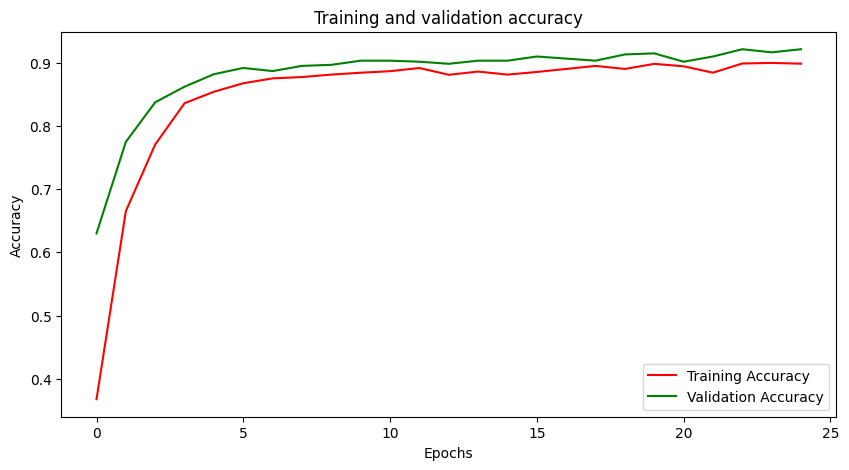

<Figure size 640x480 with 0 Axes>

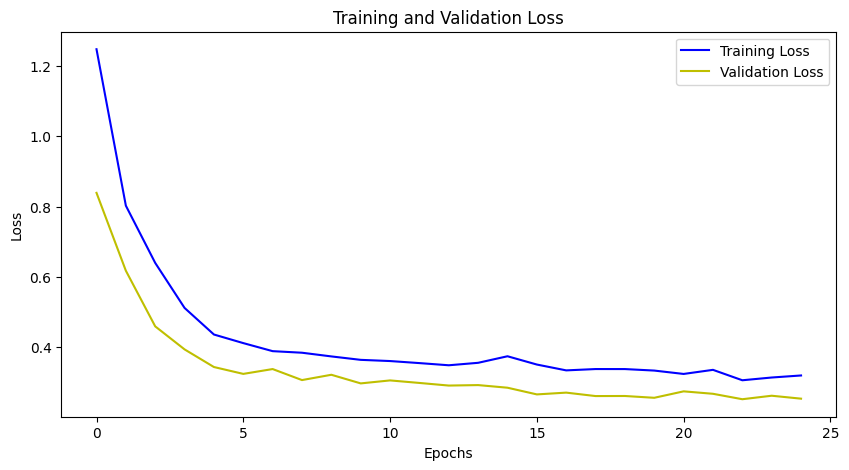

In [28]:
plot_acc_loss(history)


In [29]:
def predict(model, sample_news, class_names):

  # Convert sample news into array

  sample_news = tf.convert_to_tensor(sample_news,dtype=tf.string)

  # Predict the news type

  preds = model.predict(sample_news)

  pred_class = np.argmax(preds[0])

  print(f'predicted class: {pred_class} \nPredicted Class name: {class_names[pred_class]}')


In [30]:
sample_news = ['Tesla, a self driving car company is also planning to make a humanoid robot. This humanoid robot appeared dancing in the latest Tesla AI day']

predict(conv_rnn_model, sample_news, class_names)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
predicted class: 3 
Predicted Class name: Sci/Tech


In [31]:
sample_news = ["In the last weeks, there has been many transfer suprises in footbal. Ronaldo went back to Old Trafford, "
                "while Messi went to Paris Saint Germain to join his former colleague Neymar."
                "We can't wait to see these two clubs will perform in upcoming leagues"]


predict(conv_rnn_model, sample_news, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted class: 1 
Predicted Class name: Sports


In [32]:
sample_news = ["In the last few days the tensions between Israel and Iran are quite likely to escalate into full blown war, worrying world governments, especially over the already fluctuating prices of crude oil"]


predict(conv_rnn_model, sample_news, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
predicted class: 0 
Predicted Class name: World
